## Прогноз класса “Архетип”

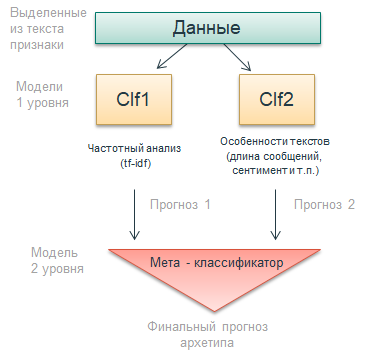

In [545]:
from IPython.display import Image
Image(filename='stacking_schema.png') 

### Модель
__Стэкинг__: 

    Фичи 1 уровня: 
    - Частотный анализ (tf-idf)
    - Особенности текстов каждого юзера (длина сообщений, сентимент и т.п.)
    
    Модель 1 уровня: Метод ближайших соседей (k=5)
    
    Фичи 2 уровня:
    - Прогнозы KNN по фичам 1 уровня
    
    Модель 2 уровня: Градиентный бустинг (lightgbm из коробки)


### Результаты на тесте:

- Архетип "Боец" - точность 90%
- Архетип "Аналитик" - точность 75%
- Архетип "Исполнитель" - точность 73%
- Архетип "Эксперт" - точность 72%
- Архетип "Эмпат" - точность 72%
- Архетип "Визионер" - точность 71%

In [15]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier

import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
import re

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1 Создание датасета для обучения и теста

### Загружаем текстовые данные


In [2]:
# изначальные
main_text = pd.read_csv('fixed_reflex_texts.csv')
# доп данные рефлексий
additional_data_text = pd.read_csv('additional_data_text.csv')

main_text.shape, additional_data_text.shape

((9128, 15), (1256, 2))

In [3]:
additional_data_text.head()

,untiID,Чему вы научились в рамках курса?
0,701335,"Оформила страницу в социальной сети, определил..."
1,1033016,До начала курса я немного был знаком с основам...
2,995121,Очень много новой информации. Научились состав...
3,674661,"Очень полезный курс, научилась грамотно вести ..."
4,969910,научилась очень многому благодаря компетенции ...


In [4]:
# Объединим основные и доп данные

additional_data_text.columns = ['untiID','value']

data = pd.concat((main_text[['untiID', 'value']], additional_data_text[['untiID','value']]))
data.shape

(10384, 2)

In [5]:
# identify id where answers are not textual
ids_no_text = []

for ind, val in zip(data.index, data['value']):
    if not isinstance(val, str):
        ids_no_text.append(ind)
        
# slice rows where answers are textual
data = data[~data.index.isin(ids_no_text)]
data.shape

(7300, 2)

## Предобработка текстовых данных

In [6]:
# Проведем очистку данных: стемминг, единый регистр, удалим знаки препинания, цифры и т.п.

def preprocess(line):
    char_regex = re.compile(r'[^а-яa-z]')
    line = char_regex.sub(' ', line.lower())
    
    tokenized = toktok.tokenize(line)
    stemmed_str = ''
    for i in tokenized:
        stemmed = stemmer.stem(i)
        stemmed_str += str(stemmed + ' ')
    return stemmed_str

In [7]:
%%time

toktok = ToktokTokenizer()
stemmer = RussianStemmer()

data['text'] = data['value'].apply(preprocess) 

Wall time: 3.27 s


In [8]:
# агрегация текстов по каждому юзеру

data_agg = data.groupby(['untiID'])['text'].apply(' '.join).reset_index()
data_agg.shape

(1294, 2)

In [9]:
data_agg[data_agg['untiID']==85]

,untiID,text
2,85,рассказа что дела и что над зачекин остав ос ...


## Загружаем результаты диагностик

In [10]:
df_train = pd.read_csv('diag_large_train.csv')
df_test = pd.read_csv('diag_test_agg.csv')

df_train.shape, df_test.shape

((1451, 327), (127, 681))

In [11]:
# Объединим тексты и результаты диагностик по каждому юзеру
# Разделим данные: трейн - db0-7 + доп.данные; тест - db8-10

train = pd.merge(data_agg, df_train, on=['untiID'])
test = pd.merge(data_agg, df_test, on=['untiID'])
test = test[train.columns.tolist()]
train.shape, test.shape

((1050, 328), (127, 328))

## Объединим агрегаты текстовых данных (длина, тональность, кол-во знаков препинания и т.д.) с результатами диагностик и текстами

In [12]:
agg_train = pd.read_csv('train.csv')
agg_test = pd.read_csv('test.csv')

agg_train.shape, agg_test.shape

((1417, 336), (110, 336))

In [13]:
# берем не все признаки. только те, которые позволили получить приемлимое качество модели

synth = ['sentiment_negative', 'sentiment_neutral','sentiment_positive', 
         'sentiment_skip','sentiment_speech','ner','answer_len',
         'upper_case_word_count','punctuation_count']

final_train = pd.merge(agg_train[synth+['untiID']], train, on=['untiID'])
final_test = pd.merge(agg_test[synth+['untiID']], test, on=['untiID'])

final_train.shape, final_test.shape

((1016, 337), (110, 337))

## Transform texts to Tf-Idf vectors

In [16]:
# Будем рассматривать юни-, би- и триграммы.
# Возьмем только топ 1000 слов, за исключением стопслов

rus_stopwords = nltk.corpus.stopwords.words('russian')

vect = TfidfVectorizer(ngram_range=(1, 4),max_features=1000, stop_words=rus_stopwords)
X_train = vect.fit_transform(final_train['text'])
X_test = vect.transform(final_test['text'])

In [17]:
import pickle

In [461]:
pickle.dump(vect, open('tfidf_vectorizer.pkl','wb'))

## 2 Modeling

In [22]:
# Сделаем бинарную разметку: свойственен ли архетип учащемуся (1) или нет (0)

def new_tgt(line):
    if line > 0:
        return 1
    else:
        return 0

def classify_behaviour_type_tfidf(type_name,title):
    """Прогноз архетипа на основе векторного представления текстов рефлексий (н граммы)"""
    y_train = final_train[type_name].apply(new_tgt)
    y_test = final_train[type_name].apply(new_tgt)
    
    model = KNeighborsClassifier(n_neighbors=5)

    model.fit(X_train, y_train)
    # прогноз на трейне будет фичей для обучения модели 2 уровня
    pred_train = model.predict(X_train)
    # прогноз на тесте - фича для тестирования модели 2 уровня
    y_pred = model.predict(X_test)
    
    pickle.dump(model, open(title+'_tf.pkl','wb'))

    return pred_train, y_pred
    
def classify_behaviour_type(type_name,title):
    """Прогноз архетипа на основе текстовых особенностей (длина сообщения, кол-во запятых итп)"""
    final_train['type'] = final_train[type_name].apply(new_tgt)
    final_test['type'] = final_test[type_name].apply(new_tgt)
    
    X_train, y_train = final_train[synth], final_train['type']
    X_test, y_test = final_test[synth], final_test['type']
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    pickle.dump(model, open(title+'_feat.pkl','wb'))
    
    return pred_train, y_pred



def predict_with_stacking(type_name, title):
    """Стэккинг: мета классификатор обучается на прогнозах моделей 1 уровная"""
    pred_train_tf, y_pred_tf = classify_behaviour_type_tfidf(type_name, title)
    pred_train_feat, y_pred_feat = classify_behaviour_type(type_name, title)
    
    y_train_new = final_train[type_name].apply(new_tgt)
    y_test_new = final_test[type_name].apply(new_tgt)

    stack_train = pd.DataFrame({'tf':pred_train_tf,
                                'feat':pred_train_feat,
                               })

    stack_test = pd.DataFrame({'tf':y_pred_tf,
                                'feat':y_pred_feat})
    stack = LGBMClassifier(random_state=1)
    stack.fit(stack_train, y_train_new)
    pred = stack.predict(stack_test)
    pickle.dump(stack, open(title+'.pkl','wb'))
    
    print("Точность (precision) {}%".format(round(precision_score(y_test_new, pred)*100, 2)))

In [23]:
predict_with_stacking('боец_sum', 'fighter')

Точность (precision) 90.0%


In [24]:
predict_with_stacking('аналитик_sum','analyst')

Точность (precision) 74.67%


In [25]:
predict_with_stacking('исполнитель_sum','performer')

Точность (precision) 72.73%


In [26]:
predict_with_stacking('эксперт_sum','expert')

Точность (precision) 72.41%


In [27]:
predict_with_stacking('эмпат_sum','empath')

Точность (precision) 71.43%


In [28]:
predict_with_stacking('визионер_sum','visioner')

Точность (precision) 70.97%
